<a href="https://colab.research.google.com/github/leshcsr/IA_imageRecognition/blob/main/IA_Pokemon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Conexión con google drive para acceder al dataset

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
%cd "/content/drive/MyDrive/"
!ls

/content/drive/MyDrive
 00af3420.java
'00f79486 (1).java'
'00f79486 (2).java'
'00f79486 (3).java'
 00f79486.java
 3e6def38.java
 464a03b8.java
 548ffb07.java
 86102d81.java
'Actividad: Visualización de datos.gdoc'
'Actividad: Visualización de datos (Mapa de palabras).gdoc'
 b434c275.java
 BalancedDataset
 checkpoints
 checkpoint.weights.h5
'Colab Notebooks'
 Conplag_version_Dataset
'Evidencia 1. Análisis de similitud empleando Inteligencia Artificial A01708987.gdoc'
'Evidencia 2: Análisis de relaciones..gdoc'
'Evidencia 2.  Reflexión sobre las ventajas desventajas del modelo mejorado. 01708987.gdoc'
'Evidencia.  Análisis general de las actividades..gdoc'
 exportedModels
 f59d9b6e.java
'fb312dc6 (1).java'
'fb312dc6 (2).java'
'fb312dc6 (3).java'
'fb312dc6 (4).java'
'fb312dc6 (5).java'
'fb312dc6 (6).java'
 fb312dc6.java
 fdc4f384.java
 ff1fc018.java
 FinalDataset
'FINAL MIGRACIÓN'
 paragraphs
 plagio_detector.h5
 PokemonData
 test_data.pkl
 texts
 train_data.pkl
 training_history.p

Importar las librerías necesarias

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import shutil
import random
from tqdm import tqdm
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Softmax, Conv2D, MaxPooling2D, Dropout, BatchNormalization, ReLU, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import ResNet50


# Preprocesamiento

Indicamos donde se encuentran las imagenes que conforman el data set. En este caso, las tenemos en la Carpeta base "Dataset", dentro de ella, se encuentran otros 2 directorios, "train" y "test".

In [ ]:
original_dataset = '/content/drive/MyDrive/PokemonData'
balanced_dataset = '/content/drive/MyDrive/BalancedDataset'

if not os.path.exists(balanced_dataset):
    os.makedirs(balanced_dataset)

class_counts = {}

# Paso 1: Contar cuántas imágenes hay por clase
for class_name in os.listdir(original_dataset):
    class_path = os.path.join(original_dataset, class_name)
    if os.path.isdir(class_path):
        image_files = os.listdir(class_path)
        class_counts[class_name] = len(image_files)

# Paso 2: Identificar el mínimo
min_count = min(class_counts.values())
print(f"Minimum images per class: {min_count}")

# Paso 3: Copiar aleatoriamente min_count imágenes de cada clase
for class_name in tqdm(class_counts.keys(), desc="Balancing classes"):
    source_dir = os.path.join(original_dataset, class_name)
    dest_dir = os.path.join(balanced_dataset, class_name)

    os.makedirs(dest_dir, exist_ok=True)

    all_images = os.listdir(source_dir)
    selected_images = random.sample(all_images, min_count)

    for img in selected_images:
        shutil.copy(os.path.join(source_dir, img), os.path.join(dest_dir, img))

print("✅ Dataset balanced and saved to:", balanced_dataset)


KeyboardInterrupt: 

In [ ]:
input_dir = '/content/drive/MyDrive/BalancedDataset'
output_dir = '/content/drive/MyDrive/FinalDataset'

split_ratios = (0.6, 0.2, 0.2)  # train, test, val

for class_name in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_name)
    images = os.listdir(class_path)

    train_and_test, val = train_test_split(images, test_size=split_ratios[2], random_state=42)
    train, test = train_test_split(train_and_test, test_size=split_ratios[1]/(split_ratios[0]+split_ratios[1]), random_state=42)

    for split_name, split_data in zip(['train', 'test', 'validation'], [train, test, val]):
        split_dir = os.path.join(output_dir, split_name, class_name)
        os.makedirs(split_dir, exist_ok=True)
        for img in split_data:
            shutil.copy(os.path.join(class_path, img), os.path.join(split_dir, img))

print("Split done and saved in:", output_dir)


✅ Split done and saved in: /content/drive/MyDrive/FinalDataset


In [92]:
#base_dir = '/content/drive/MyDrive/FinalDataset'
base_dir = '/content/drive/MyDrive/Dataset'


train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validation')


Posteriormente, aplicamos las técnicas de escalamiento y data augmentation en los datos de train y test. Para el escalamiento se aplica la normalización.

In [93]:
train_datagen = ImageDataGenerator(
							rescale = 1./255,
							rotation_range = 10,
							width_shift_range = 0.2,
							zoom_range = 0.2,
    					height_shift_range=0.2,
							horizontal_flip = True)

test_datagen = ImageDataGenerator(
							rescale = 1./255)

validation_datagen = ImageDataGenerator(
							rescale = 1./255)

Definimos un tamaño estandar para las imagenes y el tamaño del bach que usaremos posteriormente cargar las imagenes desde el directorio, con los generadores de antes.

In [94]:
batch_size = 32
input_shape = (224, 224, 3)
num_classes = 8
img_size = (224, 224)

Carga de las imágenes,

In [95]:
train_generator = train_datagen.flow_from_directory(
							train_dir,
							target_size = img_size,
							batch_size = batch_size,
							class_mode ='categorical',
							)

test_generator = test_datagen.flow_from_directory(
              test_dir,
              target_size=img_size,
              batch_size=batch_size,
              class_mode='categorical',
              )

validation_generator = validation_datagen.flow_from_directory(
              validation_dir,
              target_size=img_size,
              batch_size=batch_size,
              class_mode='categorical',
              )

Found 2655 images belonging to 8 classes.
Found 656 images belonging to 8 classes.
Found 320 images belonging to 8 classes.


In [96]:
class_counts = train_generator.classes
unique_classes, counts = np.unique(class_counts, return_counts=True)

for class_name, count in zip(train_generator.class_indices.keys(), counts):
    print(f"Clase '{class_name}': {count} muestras")

mean_samples = np.mean(counts)
is_balanced = all(np.abs(counts - mean_samples) / mean_samples < 0.2)
print(f"¿Dataset balanceado? {'Sí' if is_balanced else 'No'}")

Clase 'Abra': 332 muestras
Clase 'Aerodactyl': 331 muestras
Clase 'Arbok': 332 muestras
Clase 'Articuno': 331 muestras
Clase 'Bulbasaur': 332 muestras
Clase 'Cubone': 332 muestras
Clase 'Diglett': 332 muestras
Clase 'Ditto': 333 muestras
¿Dataset balanceado? Sí


<Figure size 640x480 with 0 Axes>

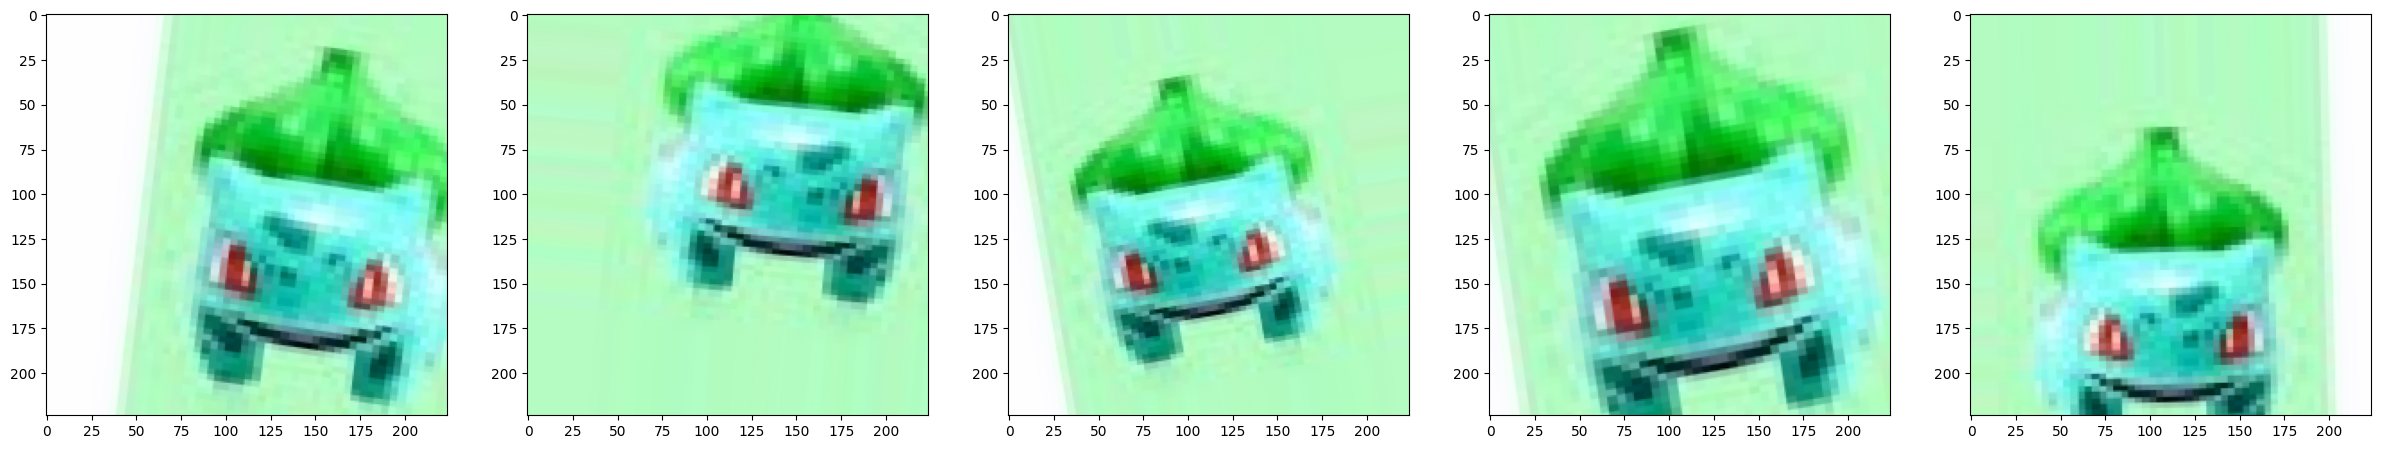

In [97]:
plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 5, figsize=(30, 8))

for i in range(5) :
  axarr[i].imshow(train_generator[1][0][0])

In [98]:
class_names = train_generator.class_indices.keys()
class_names

dict_keys(['Abra', 'Aerodactyl', 'Arbok', 'Articuno', 'Bulbasaur', 'Cubone', 'Diglett', 'Ditto'])

In [99]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

In [43]:

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = True
# Freeze all layers except the last few
for layer in base_model.layers[:-20]:
    layer.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [100]:
"""
model = models.Sequential([
    # layers from EfficientNetB0
    base_model,
    # reduce the data size keeping most important values
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    # delete random 20% of the conecctions
    layers.Dropout(0.2),
    # dense layer with 128 neurons
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    # output layer one for each class and softmax to get probability
    layers.Dense(8, activation='softmax')
])


model = Sequential([
    base_model,
    Conv2D(10, (3,3), activation='relu', input_shape=(120, 120, 3)),
    MaxPooling2D(2,2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Flatten(),
    Dense(8, activation='softmax')
])

"""
model = Sequential([
    # Bloque inicial
    Conv2D(64, kernel_size=3, padding='same', input_shape=(120, 120, 3)),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=2),  # 60x60
    Dropout(0.2),

    # Bloques profundos
    Conv2D(128, kernel_size=3, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=2),  # 30x30
    Dropout(0.2),

    Conv2D(256, kernel_size=3, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=2),  # 15x15

    Conv2D(512, kernel_size=3, padding='same'),
    BatchNormalization(),
    ReLU(),

    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(256, activation='relu'),  # Capa densa intermedia
    Dense(8, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [101]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=   "categorical_crossentropy",
              metrics =  ['accuracy'])

In [102]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 120, 120, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 120, 120, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 30, 30, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 30, 30, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 15, 15, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 15, 15, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,688,200 (6.44 MB)

 Trainable params: 1,686,280 (6.43 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [103]:
checkpoint_path = "/content/drive/MyDrive/checkpoint.weights.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_freq="epoch",
                             save_weights_only=True,
                             verbose=1)

In [104]:
checkpoint_path = "/content/drive/MyDrive/checkpoint.weights.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_freq="epoch",
                             save_weights_only=True,
                             verbose=1)

class TestPerformanceCallback(Callback):
    def __init__(self, test_generator):
        super(TestPerformanceCallback, self).__init__()
        self.test_generator = test_generator
        self.test_loss = []
        self.test_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        loss, acc = self.model.evaluate(self.test_generator, verbose=0)
        self.test_loss.append(loss)
        self.test_accuracy.append(acc)
        print(f"Epoch {epoch + 1}: Test loss = {loss:.4f}, Test accuracy = {acc:.4f}")


In [105]:
test_callback = TestPerformanceCallback(test_generator)

In [106]:
history = model.fit(
    train_generator,
    epochs=40,
    validation_data=validation_generator,
    callbacks=[checkpoint, test_callback]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3079 - loss: 1.8696
Epoch 1: saving model to /content/drive/MyDrive/checkpoint.weights.h5
Epoch 1: Test loss = 2.1524, Test accuracy = 0.1250
83/83 ━━━━━━━━━━━━━━━━━━━━ 960s 12s/step - accuracy: 0.3090 - loss: 1.8674 - val_accuracy: 0.1250 - val_loss: 2.1541
Epoch 2/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.4966 - loss: 1.4567
Epoch 2: saving model to /content/drive/MyDrive/checkpoint.weights.h5
Epoch 2: Test loss = 2.1832, Test accuracy = 0.1357
83/83 ━━━━━━━━━━━━━━━━━━━━ 38s 456ms/step - accuracy: 0.4965 - loss: 1.4568 - val_accuracy: 0.1344 - val_loss: 2.1705
Epoch 3/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.5349 - loss: 1.3670
Epoch 3: saving model to /content/drive/MyDrive/checkpoint.weights.h5
Epoch 3: Test loss = 2.2092, Test accuracy = 0.1875
83/83 ━━━━━━━━━━━━━━━━━━━━ 38s 456ms/step - accuracy: 0.5349 - loss: 1.3671 - val_accuracy: 0.1719 - val_loss: 2.1748
Epoch 4/40
83/83 ━━━━━━━━━

In [78]:
! ls -lh checkpoints

total 321M
-rw------- 1 root root 321M May 26 07:03 checkpoint.weights.h5


In [107]:
model.load_weights(checkpoint_path)

In [108]:
test_loss, test_acc = model.evaluate(test_generator)
print('\nTest accuracy:', test_acc)

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.6027 - loss: 1.2054

Test accuracy: 0.625


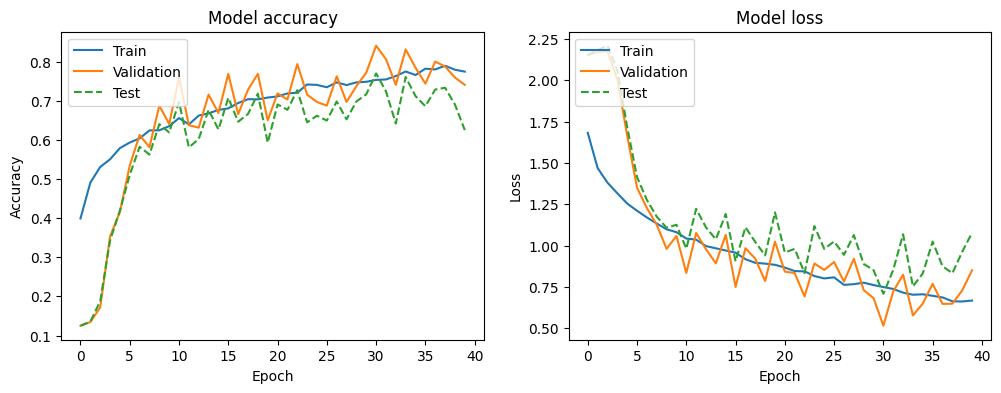

In [109]:
# Plot precisión de entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(test_callback.test_accuracy, label='Test', linestyle='--')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Test'], loc='upper left')

# Plot de la pérdida de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(test_callback.test_loss, label='Test', linestyle='--')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Test'], loc='upper left')

plt.show()

In [110]:
model.save('exportedModels/modelCNN1RestnetA3_datasetviejo.h5')

In [111]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step


In [112]:
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

print(classification_report(y_true, y_pred_classes, target_names=class_names))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
              precision    recall  f1-score   support

        Abra       0.14      0.12      0.13        40
  Aerodactyl       0.13      0.05      0.07        40
       Arbok       0.21      0.20      0.21        40
    Articuno       0.12      0.07      0.09        40
   Bulbasaur       0.13      0.17      0.15        40
      Cubone       0.14      0.07      0.10        40
     Diglett       0.23      0.20      0.21        40
       Ditto       0.16      0.38      0.23        40

    accuracy                           0.16       320
   macro avg       0.16      0.16      0.15       320
weighted avg       0.16      0.16      0.15       320



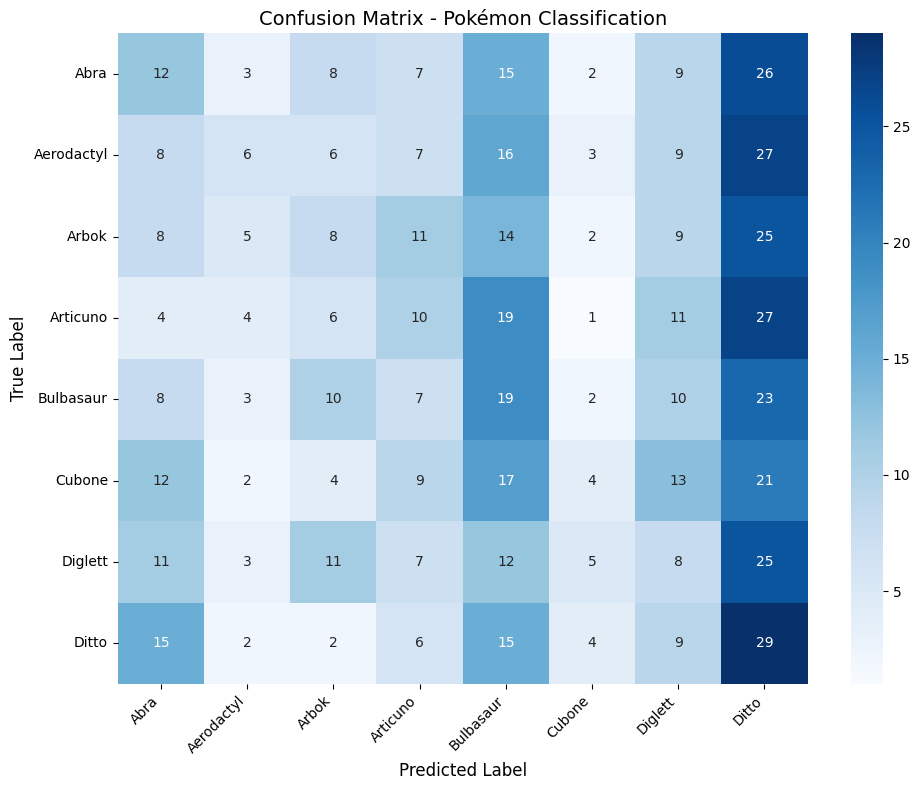

In [113]:
true_classes = test_generator.classes
confusion_mtx = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mtx,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={'size': 10}
)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Pokémon Classification', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

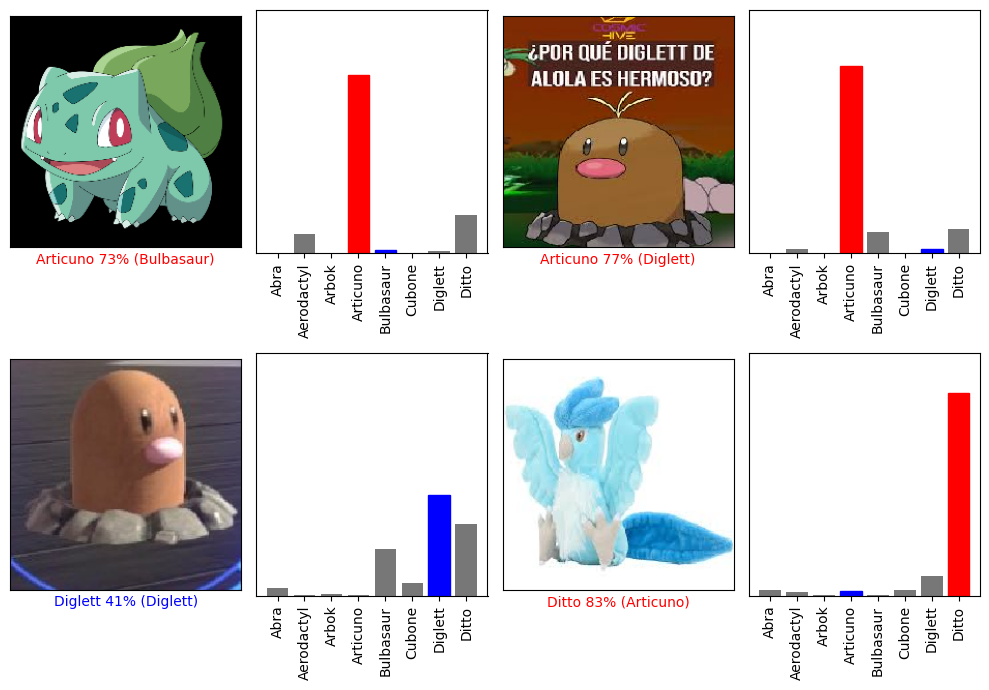

In [114]:
def plot_image(predictions_array, true_label, img, class_names):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    if img.max() > 1.0:
        plt.imshow(img.astype('uint8'))
    else:
        plt.imshow(img)

    true_label = np.argmax(true_label) if isinstance(true_label, (np.ndarray, list)) else true_label
    predicted_label = np.argmax(predictions_array)

    predicted_class = class_names[predicted_label]
    true_class = class_names[true_label]

    color = 'blue' if predicted_label == true_label else 'red'

    plt.xlabel(f"{predicted_class} {100*np.max(predictions_array):2.0f}% ({true_class})",
              color=color)

def plot_value_array(predictions_array, true_label, class_names):
    plt.grid(False)
    plt.xticks(range(len(class_names)), class_names, rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(len(class_names)), predictions_array, color="#777777")
    plt.ylim([0, 1])

    true_label = np.argmax(true_label) if isinstance(true_label, (np.ndarray, list)) else true_label
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

class_names = list(train_generator.class_indices.keys())

# Obtener batch de test
test_images, test_labels = next(test_generator)

# Configurar gráficos
num_rows = 2
num_cols = 2
plt.figure(figsize=(10, 7))
for i in range(num_rows*num_cols):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(predictions[i], test_labels[i], test_images[i], class_names)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(predictions[i], test_labels[i], class_names)
plt.tight_layout()
plt.show()